In [1]:
# Preliminaries to work with the data.   
# Assumes this notebook is in olfaction-prediction/opc_python/gerkin
%matplotlib inline
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)

import opc_python
from opc_python.utils import loading, scoring
from opc_python.gerkin import dream
import numpy as np
import matplotlib.pyplot as plt
import pandas

In [2]:
descriptors = loading.get_descriptors()
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
mdx_full = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian'],all_CIDs)
mdx_drag_morg = dream.get_molecular_data(['dragon','morgan'],all_CIDs)

Episuite has 62 features for 476 molecules.
Morgan has 2437 features for 476 molecules.
NSPDK has 6163 features for 476 molecules.
NSPDK Gramian has 2437 features for 476 molecules.
There are now 15969 total features.
Morgan has 2437 features for 476 molecules.
There are now 7307 total features.


In [3]:
# Create the feature matrices from the feature dicts.  
from sklearn.preprocessing import Imputer,MinMaxScaler
#X_all,good1,good2,means,stds,imputer = dream.make_X(mdx_drag_morg,['training','leaderboard']) # The way I did it.  
X_all2,_,_,_,_,_ = dream.make_X(mdx_drag_morg,
                                ['training','leaderboard'],raw=True) # Skip all the scaling and imputation
                                                                     # This should be the plain Dragon and 
                                                                     # Morgan featueres + negLogD + leak
X_all2[np.isnan(X_all2)] = 0 # Set all NaNs to 0.  
X_scaled = MinMaxScaler().fit_transform(X_all2[:,:-2]) # Scale everything except negLogD and Intensity to 0-1.  
X_scaled_sq = np.hstack((X_scaled,X_scaled**2,X_all2[:,-2:])) # Concatenate the linear terms, the squared terms, 
                                                              # and negLogD and leak
Y_all,imputer = dream.make_Y_obs(['training','leaderboard'],
                                 target_dilution=None,imputer='mask') # All training and leaderboard perceptual data

The X matrix now has shape (814x7308) molecules by non-NaN good molecular descriptors
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


In [4]:
import pandas as pd
linear_mean_noleak = pd.read_csv('../../data/2e_mean_noleak.csv')
linear_sem_noleak = pd.read_csv('../../data/2e_se_noleak.csv')

In [5]:
lin_importances = np.zeros((10,21,14613)) # 10 splits, 21 descriptors, 14613 features without the leak (7606*2 + negLogD)
lin_ranked = np.zeros((10,21,14613)).astype(int) # Matrix to store the score rankings.  
lin_features = pd.read_csv('../../data/linear_scores_and_features/features_dragon_morgan.csv',nrows=0)
for split in range(10):
    for desc in range(21):
        scores = pd.read_csv('../../data/linear_scores_and_features/LB_scores_morgan%d/scores_%d.csv' % (split,desc),index_col=0)
        scores.drop(['0','Intensity'],inplace=1) # Get rid of that weird "0" feature and the leak feature.  
        scores['int'] = np.arange(14613).astype(int) # Temp index to use for ranking.  
        lin_ranked[split,desc,:] = scores.sort_values(by='0',ascending=0)['int'] # Sort and store the ranking.  

In [6]:
lin_ranked[0,0,:] # The feature ranking for the first split, for intensity. 
                  # negLogD appears first, so presumably this is working.  

array([14612,  5847, 13011, ...,  5085,  5088,  7306])

In [7]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

n_features = [1,2,3,4,5,10,33,100,333,1000,3333,10000]
n_splits = 10

# This class produces a new iterator that makes sure that the training and test set do not contains the same molecule
# at different dilutions, and also that the higher concentration is tested (or 10^-3 for intensity).  
class DoubleSS:
    def __init__(self, ss, col, concs):
        self.splits = ss
        self.col = col
        self.concs = concs

    def __iter__(self):
        for train, test in self.splits:
            train = np.concatenate((2*train,2*train+1))
            if self.col>0:
                test = 2*test+1 # The second (higher) concentration of the pair
            else:
                test = np.concatenate((2*test,2*test+1))
                test = test[self.concs[test]==-3]
            yield train, test
            
    def __len__(self):
        return len(self.splits)

Y = Y_all['mean_std'] # Use the perceptual means (second 21 columns are std's which are ignored here)

In [8]:
# Produces correlations for each split for each descriptor, for varying numbers of (ranked) features.
def feature_sweep(X_all,Y,n_estimators,n_splits=n_splits,n_features=n_features,model='rf',alpha=1.0,random_state=0):
    rs = np.zeros((21,len(n_features),n_splits)) # Empty matrix to store correlations.  
    n_obs = int(X_all.shape[0]/2) # Number of molecules.  
    shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.17,random_state=0) # This will produce the splits in 
                                                                               # train/test_big that I put on GitHub
    
    for col in range(21): # For each descriptor.  
        X = X_all[:,:-1] # Remove high/low dilution feature, i.e. remove the leak.
        observed = Y[:,col] # Perceptual data for this descriptor.  
        n_features_ = list(np.array(n_features)+(col==0))
        cv = DoubleSS(shuffle_split, col, X_all[:,-2]) # Produce the correct train and test indices.  
        for j,(train,test) in enumerate(cv):
            print(col,j)
            if model == 'rf': # If the model is random forest regression.  
                est = RandomForestRegressor(n_estimators=n_estimators,max_features='auto',
                                            oob_score=False,n_jobs=8,random_state=random_state)
            elif model == 'ridge': # If the model is ridge regression. 
                est = Ridge(alpha=alpha,fit_intercept=True, normalize=False, 
                            copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=random_state)
            est.fit(X[train,:],observed[train]) # Fit the model on the training data.  
            if model == 'rf':
                importance_ranks = np.argsort(est.feature_importances_)[::-1] # Use feature importances to get ranks.  
            elif model == 'ridge':
                importance_ranks = lin_ranked[j,col,:] # Use the pre-computed ranks.
            for i,max_features in enumerate(n_features_): # For each number of features to keep...
                est.fit(X[train,:][:,importance_ranks[:max_features]],
                        observed[train]) # Fit the model on the training data with max_features features.
                predicted = est.predict(X[test,:][:,importance_ranks[:max_features]]) # Predict the test data.  
                rs[col,i,j] = np.corrcoef(predicted,observed[test])[1,0] # Compute the correlation coefficient.  

        means = rs[col,:,:].mean(axis=1) # Compute the mean correlation across splits.  
        sems = rs[col,:,:].std(axis=1)/np.sqrt(n_splits) # Compute the SEM of the correlation across splits.  
        print(('Desc. %d:'+len(n_features)*' [%.3f],') % \
              tuple([col]+[means[i] for i in range(len(n_features))])) # Print the results.  
    return rs

In [9]:
rs_0 = feature_sweep(X_scaled_sq,Y,None,model='ridge',random_state=0) # Use the linear and squared terms, 
                                                     # and negLogD with ridge regression.  

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
Desc. 0: [0.066], [0.241], [0.287], [0.325], [0.391], [0.486], [0.636], [0.692], [0.705], [0.666], [0.613], [0.584],
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
Desc. 1: [0.129], [0.235], [0.295], [0.325], [0.376], [0.491], [0.582], [0.602], [0.607], [0.593], [0.491], [0.461],
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
Desc. 2: [0.392], [0.410], [0.448], [0.445], [0.441], [0.503], [0.562], [0.561], [0.489], [0.439], [0.373], [0.346],
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
Desc. 3: [0.153], [0.279], [0.317], [0.449], [0.510], [0.579], [0.608], [0.640], [0.678], [0.638], [0.538], [0.515],
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
Desc. 4: [nan], [0.403], [0.470], [0.538], [0.580], [0.656], [0.664], [0.660], [0.623], [0.567], [0.520], [0.530],
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
Desc. 5: [0.508], [0.573], [0.554], [0.550], [0.571], [0.572], [0.564], [0.502], [0.513], [0.388], [0.285], [0.271],
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
Desc. 6: [0.003], [0

In [10]:
rs_1 = feature_sweep(X_scaled_sq,Y,None,model='ridge',random_state=1) # Use the linear and squared terms, 
                                                     # and negLogD with ridge regression.  

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
Desc. 0: [0.066], [0.241], [0.287], [0.325], [0.391], [0.486], [0.636], [0.692], [0.705], [0.666], [0.613], [0.584],
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
Desc. 1: [0.129], [0.235], [0.295], [0.325], [0.376], [0.491], [0.582], [0.602], [0.607], [0.593], [0.491], [0.461],
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
Desc. 2: [0.392], [0.410], [0.448], [0.445], [0.441], [0.503], [0.562], [0.561], [0.489], [0.439], [0.373], [0.346],
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
Desc. 3: [0.153], [0.279], [0.317], [0.449], [0.510], [0.579], [0.608], [0.640], [0.678], [0.638], [0.538], [0.515],
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
Desc. 4: [nan], [0.403], [0.470], [0.538], [0.580], [0.656], [0.664], [0.660], [0.623], [0.567], [0.520], [0.530],
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
Desc. 5: [0.508], [0.573], [0.554], [0.550], [0.571], [0.572], [0.564], [0.502], [0.513], [0.388], [0.285], [0.271],
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
Desc. 6: [0.003], [0

In [11]:
# It turns out that the random seed does not matter for the ridge regression.  
# Both seeds give the exact same fit.  

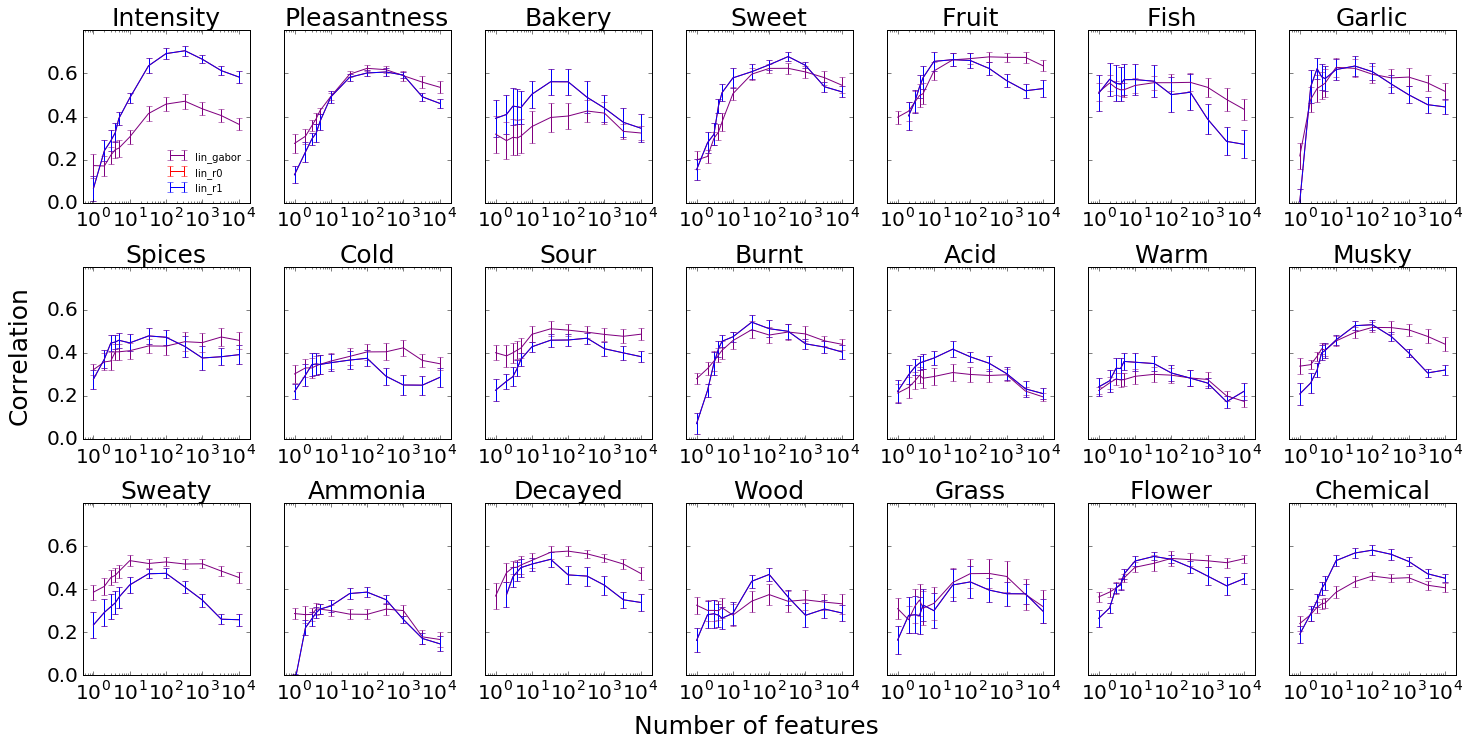

In [12]:
assert np.array_equal(np.array(n_features),np.array(linear_mean_noleak['number of features']))
fig,axes = plt.subplots(3,7,sharex=False,sharey=True,figsize=(20,10))
for col,ax in enumerate(axes.flat):
    lin_means = linear_mean_noleak[descriptors[col]]
    ax.errorbar(n_features,lin_means,linear_sem_noleak[descriptors[col]],color='purple',label='lin_gabor')
    ax.errorbar(n_features,rs_0[col].mean(axis=1),rs_0[col].std(axis=1)/np.sqrt(n_splits),color='red',label='lin_r0')
    ax.errorbar(n_features,rs_1[col].mean(axis=1),rs_1[col].std(axis=1)/np.sqrt(n_splits),color='blue',label='lin_r1')
    #ax.errorbar(n_features,forest[col].mean(axis=1),forest[col].std(axis=1)/np.sqrt(n_splits),color='green',label='forest')
    if col==0:
        ax.legend()
        handles, labels = ax.get_legend_handles_labels()
        lg = ax.legend(handles[1:], labels[1:], loc=4, fontsize=10)
        lg.draw_frame(False)
    ax.set_xlim(0.5,20000)
    ax.set_ylim(0,0.8)
    ax.set_yticks(np.linspace(0,0.6,4))
    ax.set_yticklabels([_ for _ in np.linspace(0,0.6,4)],size=20)
    ax.set_xticklabels(n_features,size=20)
    ax.set_xscale('log')
    descriptor = descriptors[col].split('/')[1 if col==1 else 0]
    descriptor = descriptor[0]+descriptor[1:].lower()
    ax.set_title(descriptor, size=25)
plt.tight_layout()
fig.text(0.5, -0.025, 'Number of features', ha='center', size=25)
fig.text(-0.02, 0.5, 'Correlation', va='center', rotation='vertical', size=25);